In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests

sns.set('talk')
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Diversity assocations

## Read in data

In [2]:
nasal_meta = pd.read_csv('../data/metadata/nasal/nasal_metadata.csv', index_col='SampleID')
nasal_meta['age_at_collection'] = (pd.to_datetime(nasal_meta['CollectionDate']) - pd.to_datetime(nasal_meta['DOB'])).dt.days
nasal_meta = pd.concat([nasal_meta,
                        pd.read_csv('../data/nasal/otu_alpha_diversity.csv', index_col='SampleID'),
                        pd.read_csv('../data/nasal/otu_nmds_babies.csv', index_col='SampleID'),
                        pd.read_csv('../data/metadata/nasal/nasal_titers_yr1.csv', index_col='SampleID')],
                       axis=1)
nasal_meta['VR_group'] = nasal_meta['VR_group'].fillna('Not Measured')
nasal_meta = nasal_meta.dropna(subset=['VisitCode']) # this drops control samples since they don't have VisitCodes (e.g. MSA2002 and GD5)
nasal_meta.tail()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
233_A2_NS_A2_Extra,Primary in Tube,1004.0,NaN,NaN,233_A2_NS_A1,Box 10_D8,Nasal Swab,Human Infant,16S,233.0,...,0.177305,0.419887,0.165297,True,True,True,True,True,True,NVR
107_V3_NS_A2,Primary in Tube,1005.0,NaN,NaN,107_V3_N!_A1,Box 10_D9,Nasal Swab,Human Infant,16S,107.0,...,0.449483,0.114018,0.958142,False,True,False,True,True,True,NVR
209_V4_NS_A2,Primary in Tube,1006.0,NaN,NaN,209_V4_NS_A1,Box 10_E1,Nasal Swab,Human Infant,16S,209.0,...,0.102041,0.105087,0.074972,False,True,False,False,True,True,NVR
107_V4_NS_2a,Primary in Tube,1007.0,NaN,NaN,NaN,Box9_E2,Nasal Swab,Human Infant,16S,107.0,...,0.449483,0.114018,0.958142,False,True,False,True,True,True,NVR
229_V2_NS_A1,Primary in Tube,1008.0,NaN,NaN,NaN,Box 10_C8,Nasal Swab,Human Infant,16S,229.0,...,0.186722,0.315442,0.158688,True,True,True,False,True,True,NVR


In [3]:
stool_nmds = pd.read_csv('../data/stool/kraken_nmds_babies.csv', index_col='SampleID')
stool_nmds.columns = ['kraken_' + i if i.startswith('MDS') else i for i in stool_nmds.columns]
stool_ko_nmds = pd.read_csv('../data/stool/ko_nmds_babies.csv', index_col='SampleID')
stool_ko_nmds.columns = ['ko_' + i if i.startswith('MDS') else i for i in stool_ko_nmds.columns]
stool_meta = pd.concat([pd.read_csv('../data/metadata/stool/stool_metadata.csv', index_col='SampleID'),
                        pd.read_csv('../data/stool/kraken_alpha_diversity.csv', index_col='SampleID'),
                        stool_nmds,
                        pd.read_csv('../data/stool/ko_alpha_diversity.csv', index_col='SampleID'),
                        stool_ko_nmds,
                        pd.read_csv('../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID')],
                       axis=1)
stool_meta = stool_meta.dropna(subset=['VisitCode'])
stool_meta = stool_meta.query('`gt_2.5`')
stool_meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
204_V5,Primary in Tube,1.0,NaN,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204.0,NaN,...,0.363970,0.192730,0.371980,False,True,True,False,False,False,LVR
226_V1,Primary in Tube,2.0,NaN,NaN,"Box 7, A2",Stool,Human Infant,MetaG,226.0,NaN,...,0.191269,0.205742,0.139576,False,True,True,True,True,True,NVR
107_V3,Primary in Tube,3.0,NaN,NaN,"Box 7, A3",Stool,Human Infant,MetaG,107.0,NaN,...,0.449483,0.114018,0.958142,False,True,False,True,True,True,NVR
108_V3,Primary in Tube,4.0,NaN,NaN,"Box 7, A4",Stool,Human Infant,MetaG,108.0,NaN,...,0.000000,0.000000,0.003102,False,False,False,False,False,True,LVR
109_V1,Primary in Tube,5.0,NaN,NaN,"Box 7, A5",Stool,Human Infant,MetaG,109.0,NaN,...,0.700925,0.763049,0.486810,True,False,False,True,True,True,NVR


## Nasal

In [4]:
nasal_titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in nasal_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div', 'MDS1', 'MDS2']:
        N_LVR = len(nasal_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].dropna())
        N_NVR = len(nasal_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].dropna())
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(nasal_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            nasal_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values,
                                           nan_policy='omit')
            nasal_titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
nasal_titer_assocs = pd.DataFrame(nasal_titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
nasal_titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value
51,V1,simpson_e_div,LVR/NVR,3,18,9.0,0.079699
3,V4,MDS1,LVR/NVR,5,12,47.0,0.081771
59,V11,MDS2,LVR/NVR,7,45,220.0,0.097128
29,V7,MDS2,LVR/NVR,11,54,204.0,0.105591
46,V6,simpson_e_div,LVR/NVR,11,52,206.0,0.150048


In [5]:
nasal_titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in nasal_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div', 'MDS1', 'MDS2']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(nasal_meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(nasal_meta.query("VisitCode == @timepoint")[div_metric].values,
                                             nasal_meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                nasal_titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
nasal_titer_correls = pd.DataFrame(nasal_titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
nasal_titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
44,V10,MDS2,median_mmNorm_PCV,55,-0.535735,0.000030
32,V10,n_otus_div,median_mmNorm_PCV,55,0.459858,0.000468
42,V10,MDS2,median_mmNorm,58,-0.430231,0.000837
38,V10,shannon_div,median_mmNorm_PCV,55,0.385859,0.003956
30,V10,n_otus_div,median_mmNorm,58,0.372909,0.004278


In [6]:
nasal_col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
nasal_titer_stats = pd.concat([nasal_titer_assocs, nasal_titer_correls]).sort_values('p_value')
nasal_titer_stats['body_site'] = 'nasal'
nasal_titer_stats = nasal_titer_stats[nasal_col_order]
nasal_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
44,nasal,V10,MDS2,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.535735,0.000030
32,nasal,V10,n_otus_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.459858,0.000468
42,nasal,V10,MDS2,median_mmNorm,NaN,NaN,58.0,NaN,-0.430231,0.000837
38,nasal,V10,shannon_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.385859,0.003956
30,nasal,V10,n_otus_div,median_mmNorm,NaN,NaN,58.0,NaN,0.372909,0.004278


In [7]:
nasal_titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
44,nasal,V10,MDS2,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.535735,0.000030
32,nasal,V10,n_otus_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.459858,0.000468
42,nasal,V10,MDS2,median_mmNorm,NaN,NaN,58.0,NaN,-0.430231,0.000837
38,nasal,V10,shannon_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.385859,0.003956
30,nasal,V10,n_otus_div,median_mmNorm,NaN,NaN,58.0,NaN,0.372909,0.004278
154,nasal,V1,simpson_e_div,median_mmNorm_DTAPHib,NaN,NaN,40.0,NaN,0.459740,0.036008
41,nasal,V10,MDS1,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.272346,0.046334


## Stool

In [8]:
stool_titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in stool_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon', 'ko_richness', 'ko_evenness', 'ko_shannon', 'kraken_MDS1', 'kraken_MDS2', 'ko_MDS1', 'ko_MDS2']:
        N_LVR = len(stool_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].dropna())
        N_NVR = len(stool_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].dropna())
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(stool_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            stool_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values,
                                            nan_policy='omit')
            stool_titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
stool_titer_assocs = pd.DataFrame(stool_titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
stool_titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value
50,V7,genus_richness,LVR/NVR,11,39,321.0,0.013037
119,V11,ko_MDS2,LVR/NVR,5,22,18.0,0.019051
112,V11,genus_shannon,LVR/NVR,5,22,18.0,0.019051
78,V2,ko_MDS1,LVR/NVR,6,33,157.0,0.022321
74,V2,ko_evenness,LVR/NVR,6,33,43.0,0.028014


In [9]:
stool_titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in stool_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon', 'ko_richness', 'ko_evenness', 'ko_shannon', 'kraken_MDS1', 'kraken_MDS2', 'ko_MDS1', 'ko_MDS2']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(stool_meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(stool_meta.query("VisitCode == @timepoint")[div_metric].values,
                                             stool_meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                stool_titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
stool_titer_correls = pd.DataFrame(stool_titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
stool_titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
124,V5,genus_evenness,median_mmNorm_DTAPHib,43,-0.501134,0.000619
207,V9,ko_MDS2,median_mmNorm,42,0.428571,0.004630
192,V9,ko_evenness,median_mmNorm,42,0.376388,0.014020
283,V6,ko_evenness,median_mmNorm_DTAPHib,45,-0.360627,0.014950
147,V5,ko_MDS2,median_mmNorm,43,-0.360163,0.017674


In [10]:
stool_col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
stool_titer_stats = pd.concat([stool_titer_assocs, stool_titer_correls]).sort_values('p_value')
stool_titer_stats['body_site'] = 'stool'
stool_titer_stats = stool_titer_stats[stool_col_order]
stool_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619
207,stool,V9,ko_MDS2,median_mmNorm,NaN,NaN,42.0,NaN,0.428571,0.004630
50,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037
192,stool,V9,ko_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.376388,0.014020
283,stool,V6,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.360627,0.014950


In [11]:
stool_titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619
207,stool,V9,ko_MDS2,median_mmNorm,NaN,NaN,42.0,NaN,0.428571,0.004630
50,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037
192,stool,V9,ko_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.376388,0.014020
283,stool,V6,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.360627,0.014950
147,stool,V5,ko_MDS2,median_mmNorm,NaN,NaN,43.0,NaN,-0.360163,0.017674
119,stool,V11,ko_MDS2,LVR/NVR,5.0,22.0,NaN,18.0,NaN,0.019051
112,stool,V11,genus_shannon,LVR/NVR,5.0,22.0,NaN,18.0,NaN,0.019051
148,stool,V5,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.356053,0.019110
149,stool,V5,ko_MDS2,median_mmNorm_PCV,NaN,NaN,40.0,NaN,-0.366604,0.019979


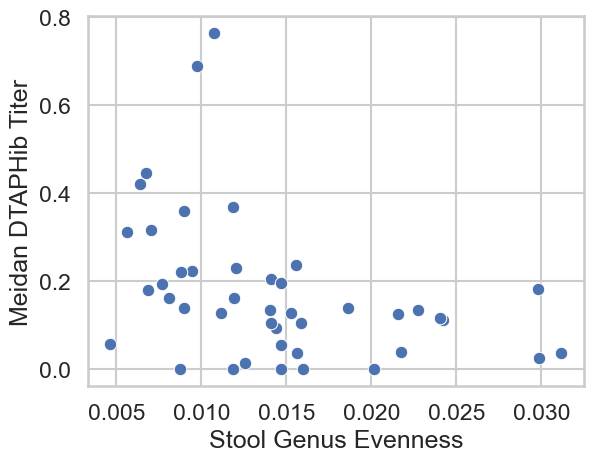

In [12]:
sns.scatterplot(x='genus_evenness',
                y='median_mmNorm_DTAPHib',
                data=stool_meta.query("VisitCode == 'V5'"))
plt.xlabel('Stool Genus Evenness')
plt.ylabel('Meidan DTAPHib Titer')
plt.savefig("../figures/2_mo_kraken_evenness_1_yr_dtaphib_correlation.pdf", bbox_inches='tight', dpi=300) 

## Combined analysis

In [13]:
titer_stats = pd.concat([nasal_titer_stats, stool_titer_stats]).sort_values('p_value')

In [14]:
titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
44,nasal,V10,MDS2,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.535735,0.000030
32,nasal,V10,n_otus_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.459858,0.000468
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619
42,nasal,V10,MDS2,median_mmNorm,NaN,NaN,58.0,NaN,-0.430231,0.000837
38,nasal,V10,shannon_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,0.385859,0.003956
30,nasal,V10,n_otus_div,median_mmNorm,NaN,NaN,58.0,NaN,0.372909,0.004278
207,stool,V9,ko_MDS2,median_mmNorm,NaN,NaN,42.0,NaN,0.428571,0.004630
50,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037
192,stool,V9,ko_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.376388,0.014020
283,stool,V6,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.360627,0.014950


In [15]:
vaccine_times = ['V5', 'V6', 'V7', 'V9']
titer_stats_vax = titer_stats.query('timepoint in @vaccine_times').sort_values(['timepoint', 'div_metric', 'titer_measure'])
titer_stats_vax['p_adj'] = p_adjust(titer_stats_vax['p_value'])
titer_stats_vax = titer_stats_vax.sort_values('p_adj')
titer_stats_vax.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619,0.148650
283,stool,V6,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.360627,0.014950,0.551614
186,stool,V9,genus_shannon,median_mmNorm,NaN,NaN,42.0,NaN,0.355968,0.020686,0.551614
149,stool,V5,ko_MDS2,median_mmNorm_PCV,NaN,NaN,40.0,NaN,-0.366604,0.019979,0.551614
50,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037,0.551614
148,stool,V5,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.356053,0.019110,0.551614
147,stool,V5,ko_MDS2,median_mmNorm,NaN,NaN,43.0,NaN,-0.360163,0.017674,0.551614
192,stool,V9,ko_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.376388,0.014020,0.551614
207,stool,V9,ko_MDS2,median_mmNorm,NaN,NaN,42.0,NaN,0.428571,0.004630,0.551614
183,stool,V9,genus_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.345434,0.025053,0.601283


In [16]:
titer_stats.query('timepoint in @vaccine_times and titer_measure == "LVR/NVR"').sort_values('p_value')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
50,stool,V7,genus_richness,LVR/NVR,11.0,39.0,NaN,321.0,NaN,0.013037
52,stool,V7,genus_shannon,LVR/NVR,11.0,39.0,NaN,298.0,NaN,0.051918
91,stool,V6,genus_evenness,LVR/NVR,12.0,33.0,NaN,123.0,NaN,0.055858
53,stool,V7,ko_richness,LVR/NVR,11.0,39.0,NaN,286.0,NaN,0.096340
29,nasal,V7,MDS2,LVR/NVR,11.0,54.0,NaN,204.0,NaN,0.105591
56,stool,V7,kraken_MDS1,LVR/NVR,11.0,39.0,NaN,284.0,NaN,0.106107
96,stool,V6,kraken_MDS1,LVR/NVR,12.0,33.0,NaN,255.0,NaN,0.147017
46,nasal,V6,simpson_e_div,LVR/NVR,11.0,52.0,NaN,206.0,NaN,0.150048
22,nasal,V5,shannon_div,LVR/NVR,8.0,57.0,NaN,156.0,NaN,0.156080
90,stool,V6,genus_richness,LVR/NVR,12.0,33.0,NaN,253.0,NaN,0.161827


In [17]:
dtaphib_vax_stats = titer_stats.query('timepoint in @vaccine_times and titer_measure == "median_mmNorm_DTAPHib"').sort_values('p_value')
dtaphib_vax_stats['p_adj'] = p_adjust(dtaphib_vax_stats['p_value'])
dtaphib_vax_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619,0.037163
283,stool,V6,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.360627,0.014950,0.382210
148,stool,V5,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.356053,0.019110,0.382210
166,stool,V7,ko_shannon,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,-0.294932,0.037596,0.455062
163,stool,V7,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,-0.277540,0.051010,0.455062


In [18]:
dtaphib_vax_stats.query('div_metric == "genus_evenness"')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
124,stool,V5,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,43.0,NaN,-0.501134,0.000619,0.037163
184,stool,V9,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,42.0,NaN,0.200308,0.203407,0.504813
274,stool,V6,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,45.0,NaN,-0.167980,0.270028,0.570356
154,stool,V7,genus_evenness,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,-0.084602,0.559121,0.745495


In [19]:
pcv_vax_stats = titer_stats.query('timepoint in @vaccine_times and titer_measure == "median_mmNorm_PCV"').sort_values('p_value')
pcv_vax_stats['p_adj'] = p_adjust(pcv_vax_stats['p_value'])
pcv_vax_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
149,stool,V5,ko_MDS2,median_mmNorm_PCV,NaN,NaN,40.0,NaN,-0.366604,0.019979,0.576567
209,stool,V9,ko_MDS2,median_mmNorm_PCV,NaN,NaN,39.0,NaN,0.331377,0.039327,0.576567
194,stool,V9,ko_evenness,median_mmNorm_PCV,NaN,NaN,39.0,NaN,0.327126,0.042079,0.576567
170,stool,V7,kraken_MDS1,median_mmNorm_PCV,NaN,NaN,47.0,NaN,0.284574,0.052537,0.576567
92,nasal,V9,n_otus_div,median_mmNorm_PCV,NaN,NaN,64.0,NaN,0.234853,0.063916,0.576567


In [20]:
cross_vax_stats = titer_stats.query('timepoint in @vaccine_times and titer_measure == "median_mmNorm"').sort_values('p_value')
cross_vax_stats['p_adj'] = p_adjust(cross_vax_stats['p_value'])
cross_vax_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
207,stool,V9,ko_MDS2,median_mmNorm,NaN,NaN,42.0,NaN,0.428571,0.004630,0.277808
192,stool,V9,ko_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.376388,0.014020,0.300641
147,stool,V5,ko_MDS2,median_mmNorm,NaN,NaN,43.0,NaN,-0.360163,0.017674,0.300641
186,stool,V9,genus_shannon,median_mmNorm,NaN,NaN,42.0,NaN,0.355968,0.020686,0.300641
183,stool,V9,genus_evenness,median_mmNorm,NaN,NaN,42.0,NaN,0.345434,0.025053,0.300641
